# <center>Structural Analysis and Visualization of Networks</center>

## <center>Home Assignment #4: Community Detection Algorithms

### <center>Student: *{Sukmanova Elena}*</center>

#### <hr /> General Information

**Due Date:** 03.04.2016 23:59 <br \>
**Late submission policy:** the task will not be graded! <br \>


Please send your reports to <network.hse.2016@gmail.com> with message subject of the following structure:<br \> **[HSE Networks 2015] *{LastName}* *{First Name}* HA*{Number}***

Support your computations with figures and comments. <br \>
If you are using IPython Notebook you may use this file as a starting point of your report.<br \>
<br \>
<hr \>

## Problems

### Task 1* (For those who have not done that during the seminar)

On this seminar your are asked to implement simple community detection algorithm. It is called [Markov Cluster Algorithm](http://micans.org/mcl/) (MCL).

Implement Markov Clustering Algorithm

**Input:** Transition matrix $T = D^{-1}A$

**Output:** Adjacency matrix $M^*$

1. Set $M = T$
2. **repeat:**
    3. *Expansion Step:* $M = M^p$ (usually $p=2$)
    4. *Inflation Step:* Raise every entry of $M$ to the power $\alpha$ (usualy $\alpha=2$)
    5. *Renormalize:* Normalize each row by its sum
    6. *Prunning:* Replace entries that are close to $0$ by pure $0$
7. **until** $M$ converges
8. $M^* = M$
<br\>
<br\>

As a result you should get a cluster matrix s.t. elements of the cluster correspond to nonzero elements of the columns of the matrix. 
<br\>
* Run this method for network [1](https://www.hse.ru/data/2016/03/15/1127695811/network1.mat), [2](https://www.hse.ru/data/2016/03/15/1127699956/network2.mat) and [3](https://www.hse.ru/data/2016/03/15/1127703057/network3.mat).
* Play with the parameters ($p$, $\alpha$, zero tolerance), analyse the results

### Solutions:

In [1]:
## let's import some libraries
import numpy as np
import matplotlib.pyplot as plt
plt.xkcd()
import networkx as nx
%matplotlib inline
import scipy.io

In [2]:
## Markov Cluster Algorithm
def MCA(A, tol, p, alpha):
    step = 1
    col_sums = A.sum(axis = 0)
    T = A / col_sums[np.newaxis, :]
    M = T
    while(1):
        step += 1
        # Expancion step:
        M1 = np.linalg.matrix_power(M, p)
        # Inflation step:
        M1 = np.power(M1, alpha)
        col_sums = M1.sum(axis = 0)
        M1 = M1 / col_sums[np.newaxis, :]
        M1[M1<=tol] = 0
        if np.linalg.norm(M - M1) == 0:
            return M1, step
        else:
            M = M1.copy()

In [3]:
## draw resulting graph after implemention of Markov Cluster Algorithm
def draw_MCA_result(A, tol, p, alpha, pos, comm):
    M1, step = MCA(A, tol, p, alpha)
    G1 = nx.DiGraph(M1)
    plt.figure(figsize=(20,10))
    plt.title('Resulting graph after {} steps with following parameters:\
                \ntol = {}, p = {}, alpha = {}'.format(step, tol, p, alpha))
    nx.draw_networkx(G1, pos = pos, node_color = comm, alpha = 0.6, with_labels = False)

In [4]:
## final analysis
def analysis(filename):
    # download data
    data = scipy.io.loadmat(filename+'.mat')
    A = data['A'].astype('float')
    comm = data['Comm']
    # draw initial graph
    G = nx.DiGraph(A)
    pos = nx.spring_layout(G)
    plt.figure(figsize=(20,10))
    plt.title('Initial graph of {}'.format(filename))
    nx.draw_networkx(G, pos = pos, node_color = comm, alpha = 0.6, with_labels = False)
    # implement Markov Cluster Algorithm with diffirent parameters and draw result
    draw_MCA_result(A, 0.01, 2, 2, pos, comm)
    draw_MCA_result(A, 0.03, 2, 2, pos, comm)
    draw_MCA_result(A, 0.01, 5, 5, pos, comm)

#### Run this method for network 1, 2 and 3 and play with the parameters (p, α, zero tolerance), analyse the results.

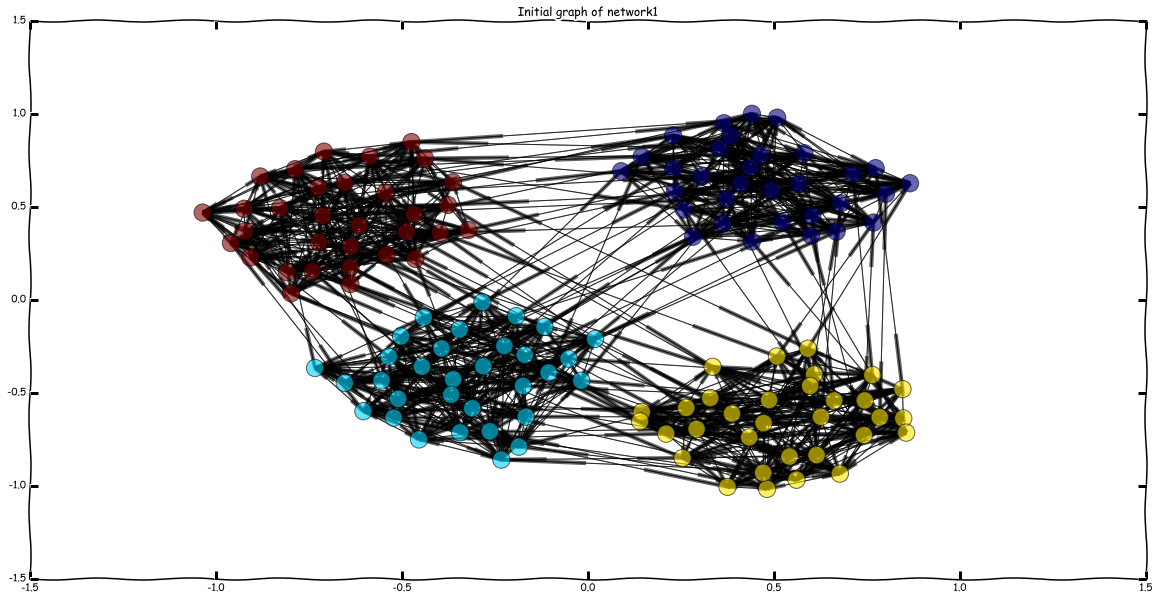

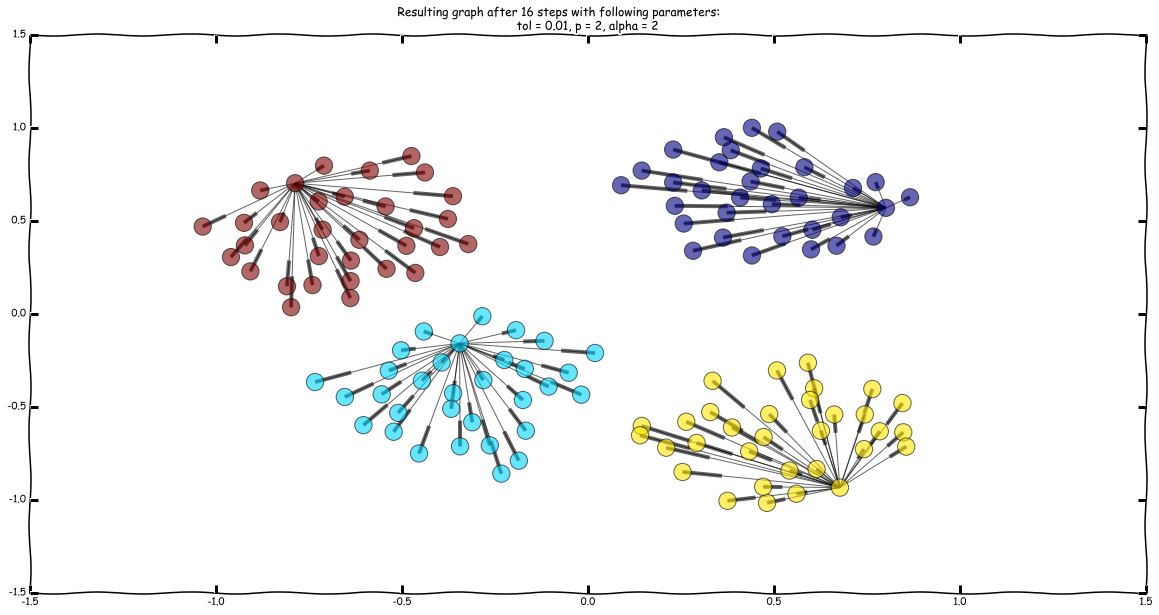

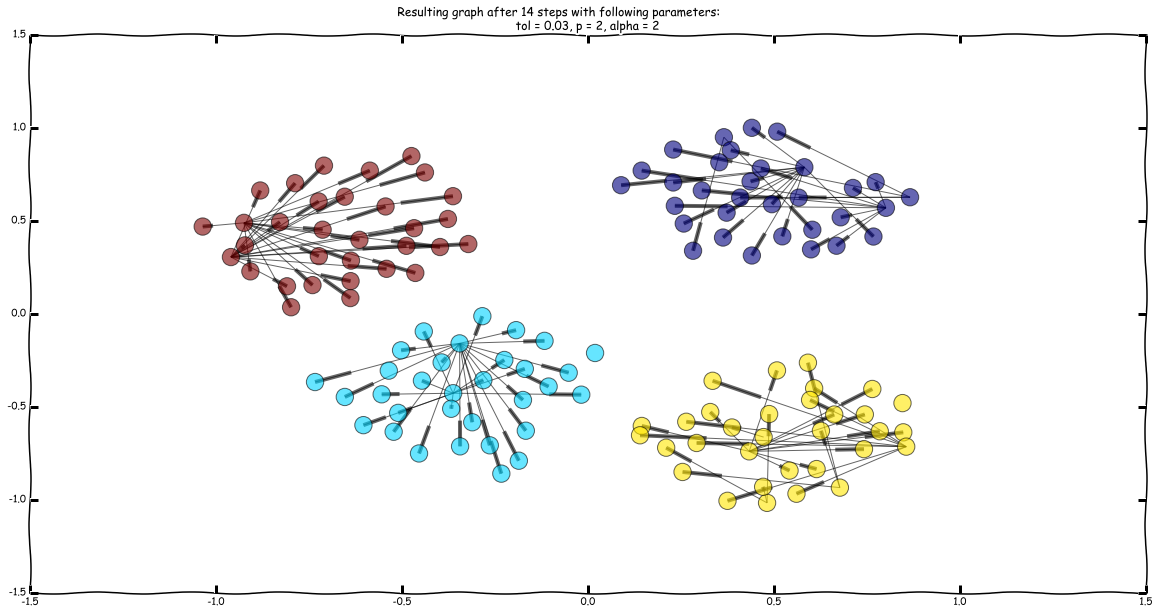

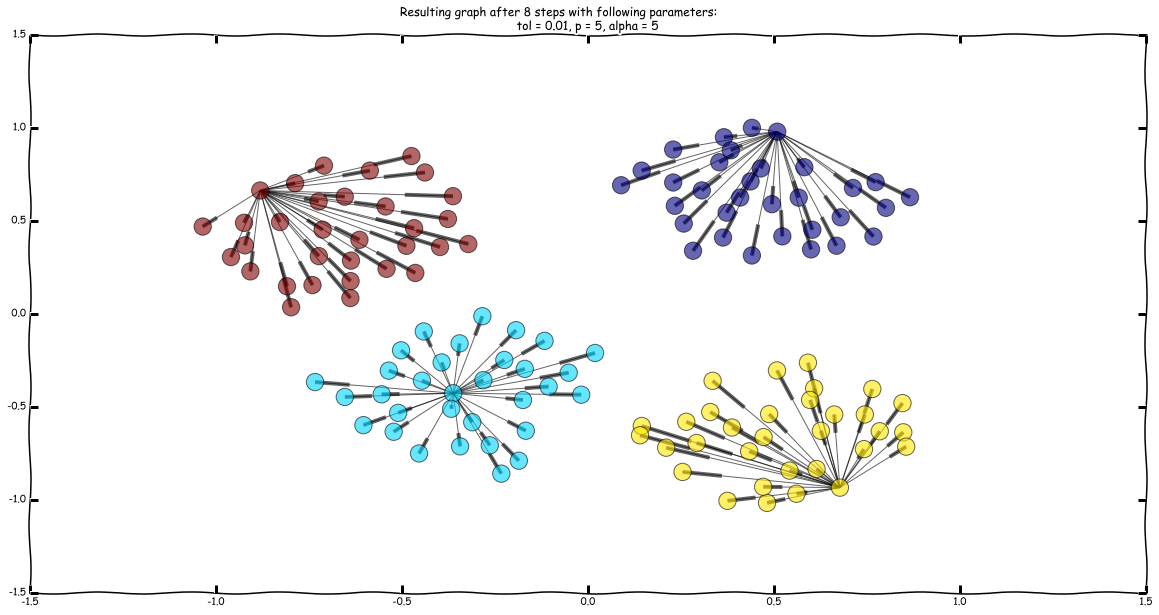

In [5]:
analysis('network1')

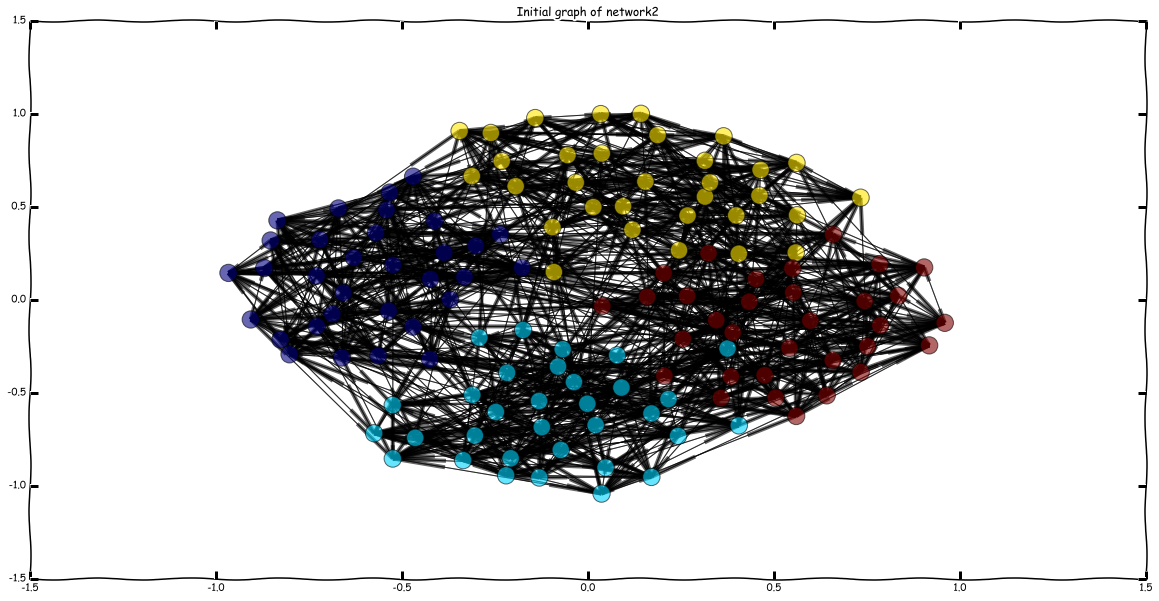

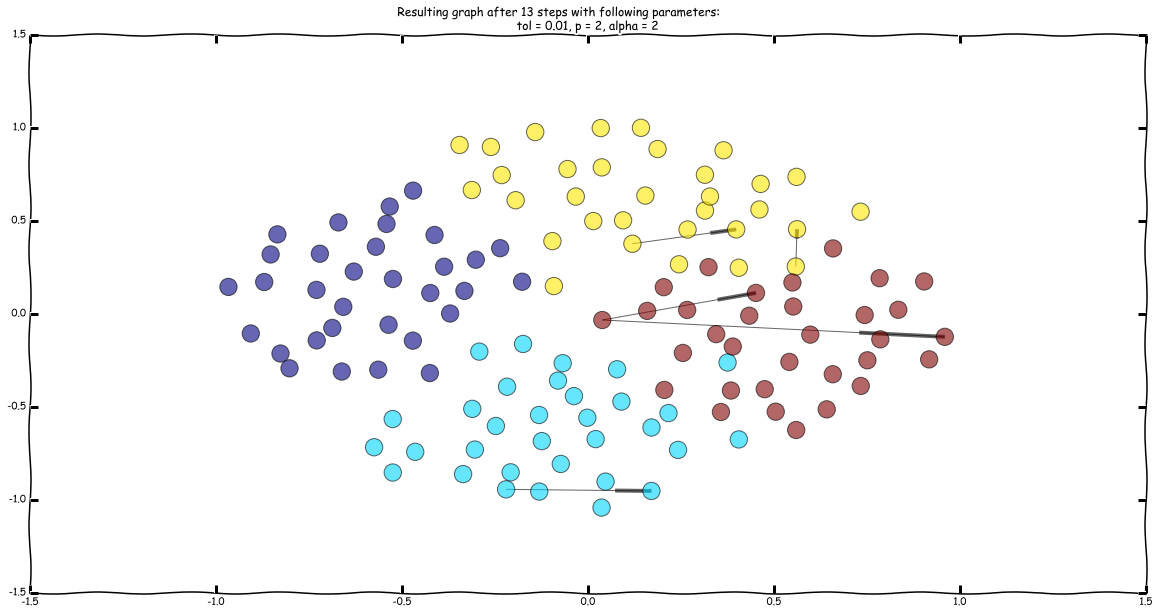

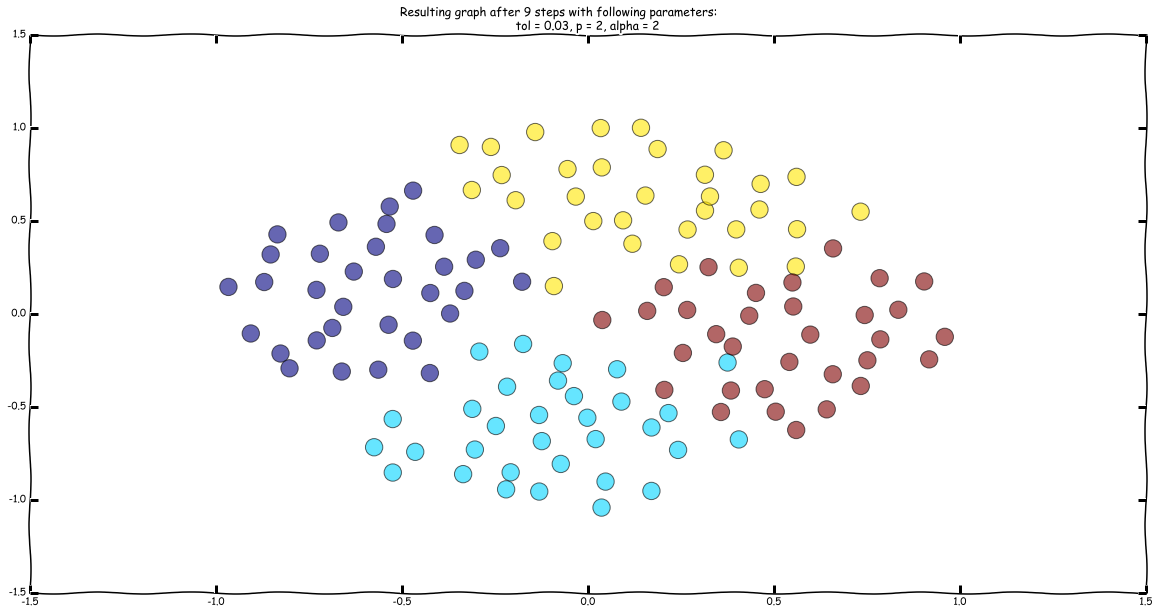

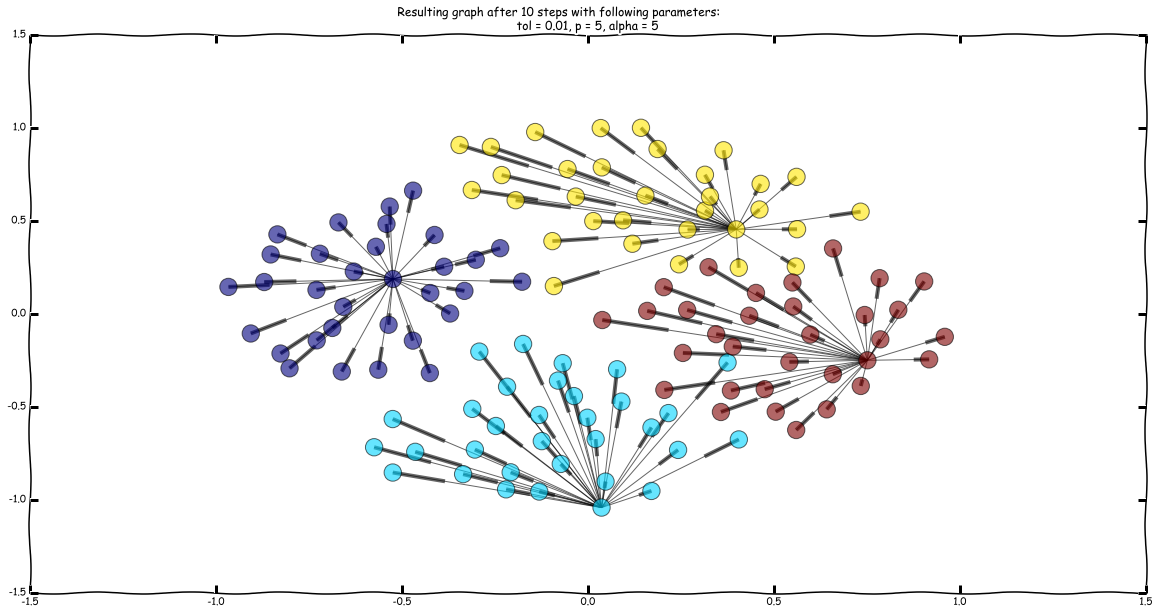

In [6]:
analysis('network2')

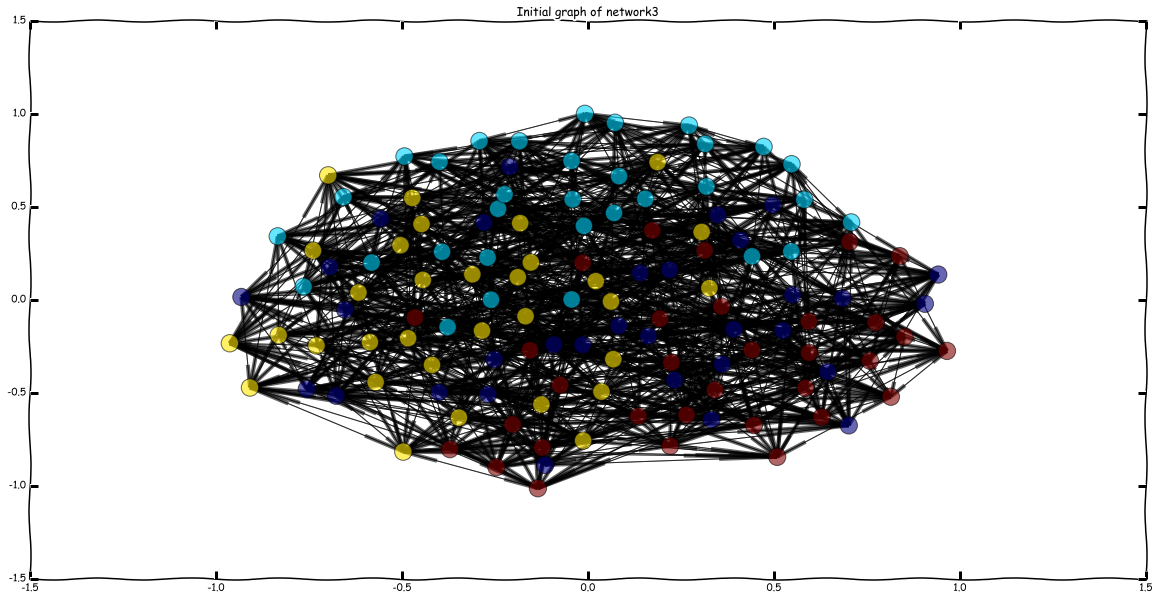

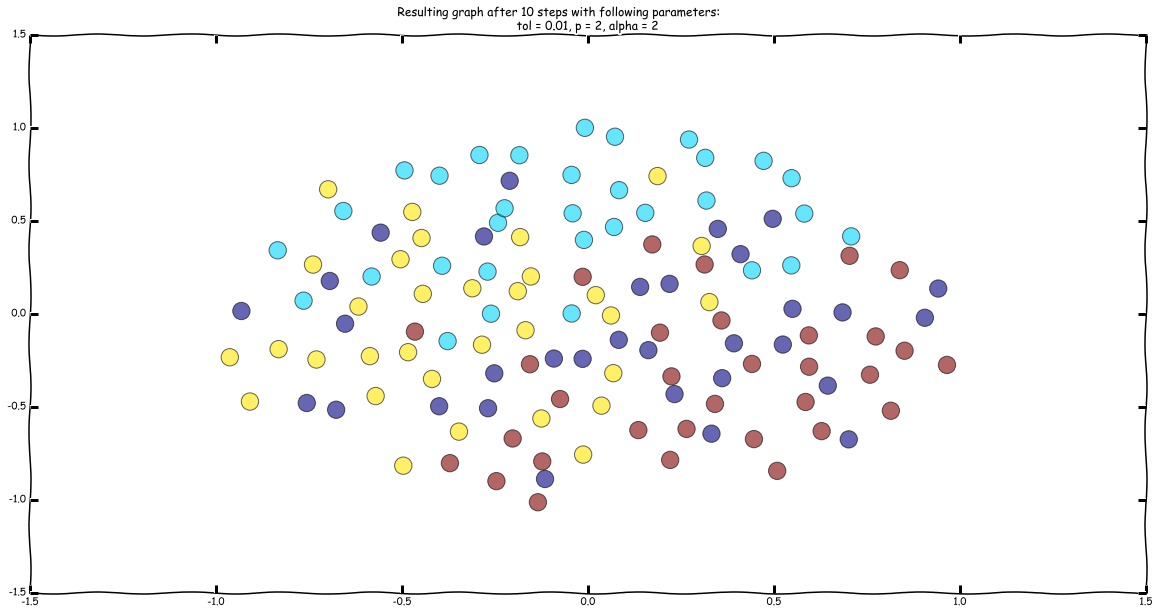

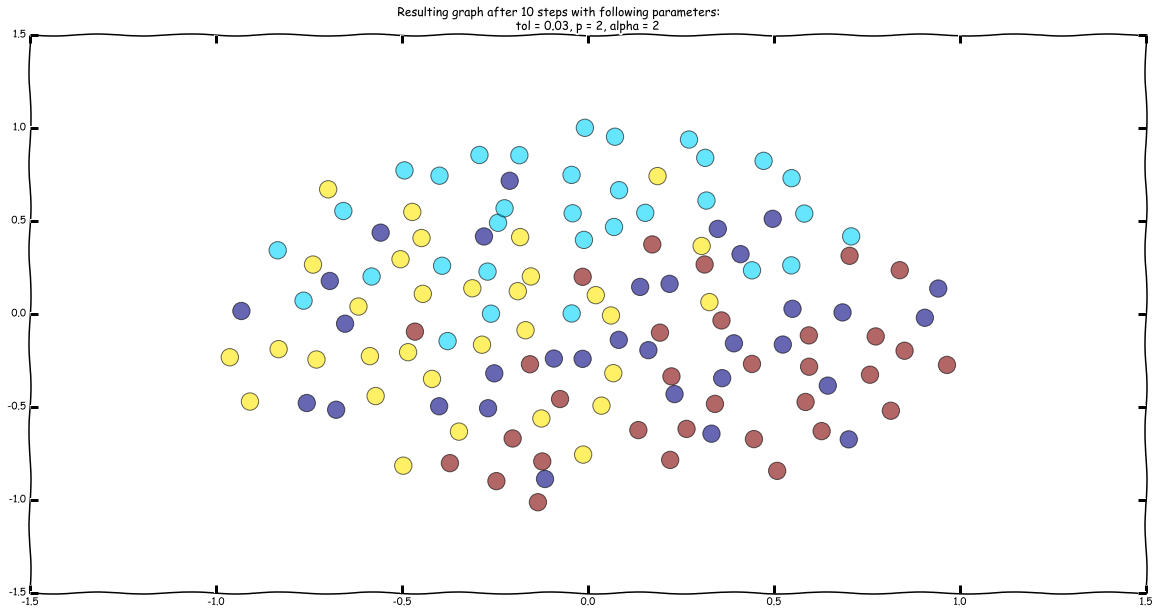

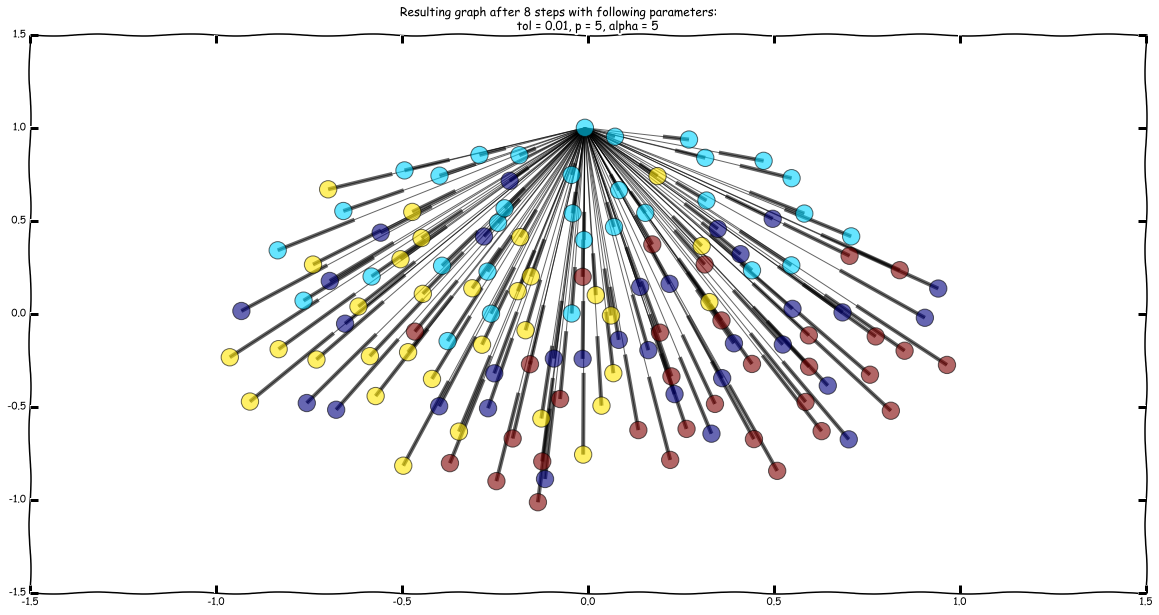

In [7]:
analysis('network3')

So we can conclude that:

- The inflation operator 'alpha' is responsible for both strengthening and weakening of current (strengthens strong currents and weakens weak currents). This parameter affects cluster granularity.

- The expansion operator 'p' is responsible for allowing flow to connect different regions of the graph. This parameter affects time of computation and partially cluster granularity.

- The pruning operator 'tol' speeds up the computation.

From plots above we can draw conclusions that correct selection of parameters depends on sparsity of initial graph.

### Task 2

Load [Yahoo Music network](https://www.hse.ru/data/2016/03/15/1127704844/music_data.mat). Edges in this network appear if enough number of users have given ratings to both music bands. Note, that edges are weighted with similarity of the ratings.

* Implement *multilevel spectral recursive partitioning* algorithm that was described during the lecture
* Visualize community structure of the network and output some of the dense clusters (with interpretation, if you can)

### Solutions:

#### Implement multilevel spectral recursive partitioning algorithm that was described during the lecture.

In [8]:
## data preparation
data = scipy.io.loadmat('music_data.mat')
artists = data['artists']
A = data['A'].ceil()

In [9]:
## Multilevel Spectral Recursive Partitioning Algorithm
def MSRPA(adjacency_matrix, artists):
    # compute Laplacian matrix
    D = np.diagflat(adjacency_matrix.sum(axis = 1))
    D = scipy.sparse.csr_matrix(D)
    L = D - adjacency_matrix
    # solve for second smallest eigenvector
    w, v = scipy.sparse.linalg.eigsh(L, k = 2, M = D, which = 'SM')
    x2 = v[:,np.argmax(w)]
    # make list of sorted vertices (by values of second smallest eigenvector)
    ordered_vertices = np.argsort(x2)
    # reorder columns and rows in adjacency matrix
    adjacency_matrix = adjacency_matrix[:, ordered_vertices]
    adjacency_matrix = adjacency_matrix[ordered_vertices, :]
    # reorder list with artists names
    artists = artists[ordered_vertices]
    # make signs of sorted second smallest eigenvector
    x2 = np.sign(x2[ordered_vertices])
    # find breaking point on two communities
    bp = np.where(x2 == 1)[0][0]
    
    if nx.density(nx.Graph(adjacency_matrix[:bp, :bp])) < 0.25 and adjacency_matrix[:bp, :bp].shape[0] > 100:
        adjacency_matrix[:bp, :bp], artists[:bp] = MSRPA(adjacency_matrix[:bp, :bp], artists[:bp])
    elif nx.density(nx.Graph(adjacency_matrix[:bp, :bp])) > 0.45:
        print('One more community with high density:')
        print(artists[:bp])
    
    if nx.density(nx.Graph(adjacency_matrix[bp:, bp:])) < 0.25 and adjacency_matrix[bp:, bp:].shape[0] > 100:
        adjacency_matrix[bp:, bp:], artists[bp:] = MSRPA(adjacency_matrix[bp:, bp:], artists[bp:])
    elif nx.density(nx.Graph(adjacency_matrix[bp:, bp:])) > 0.45:
        print('One more community with high density:')
        print(artists[bp:])
        
    return adjacency_matrix, artists

#### Visualize community structure of the network and output some of the dense clusters.

In [10]:
import warnings
warnings.filterwarnings('ignore')

final_A, artists = MSRPA(A, artists)

One more community with high density:
['Lonestar                                           '
 'Phil Vassar                                        '
 'Kellie Coffey                                      '
 'Montgomery Gentry                                  '
 'Brad Paisley                                       '
 'Joe Nichols                                        '
 'Gary Allan                                         '
 'The Warren Brothers                                '
 'Soggy Bottom Boys                                  '
 'Trace Adkins                                       '
 'Dusty Drake                                        '
 'Kevin Denney                                       '
 'Jennifer Hanson                                    '
 'Keith Urban                                        '
 'Craig Morgan                                       '
 'Jimmy Wayne                                        '
 'Chris Cagle                                        '
 'Deric Ruttan             

As we can see dense clusters correspond to popular music genres.

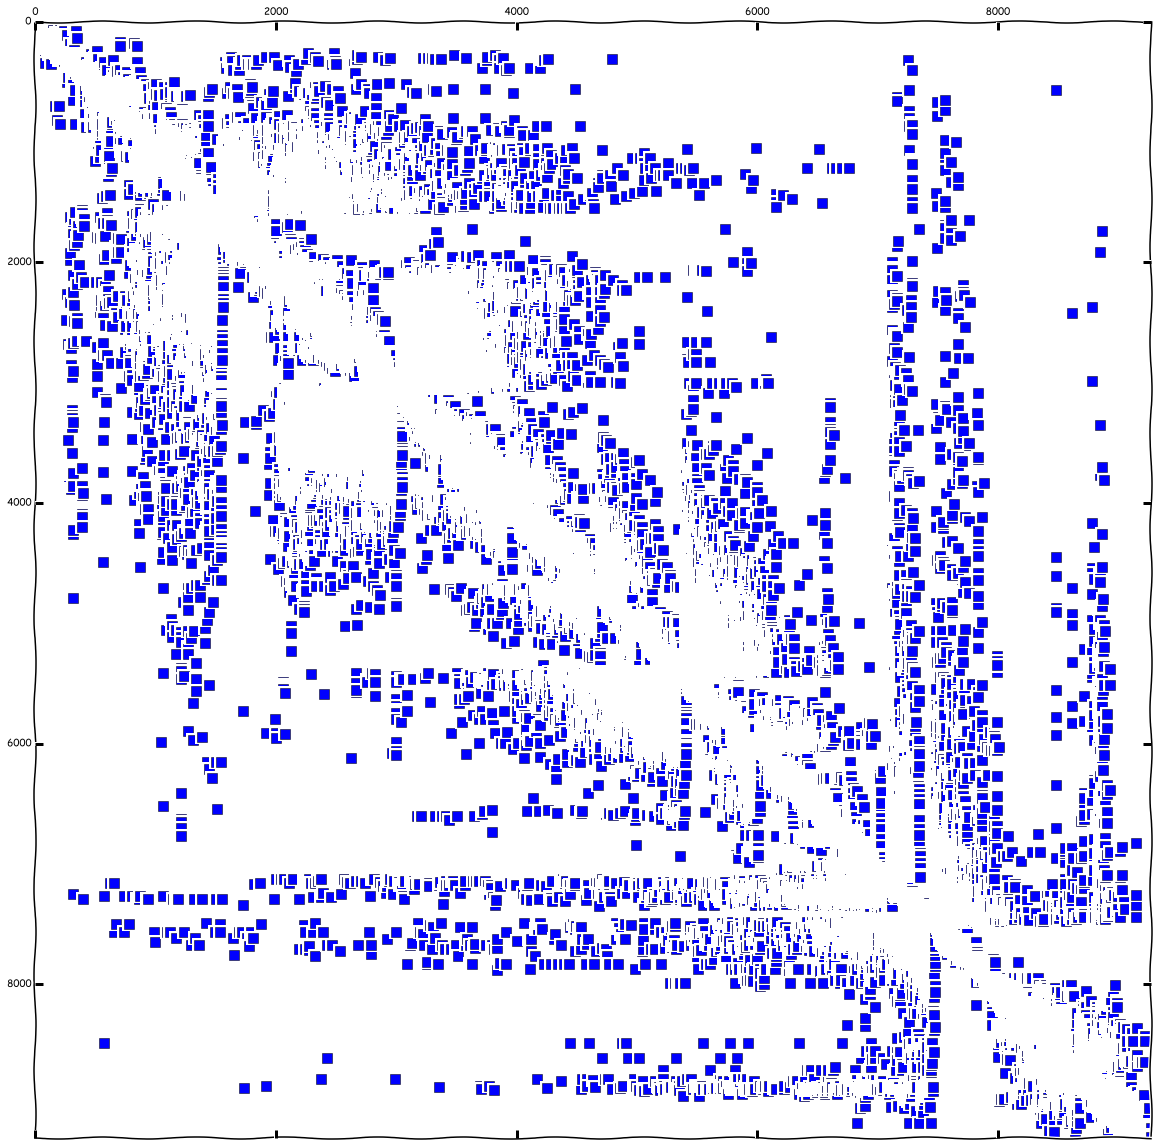

In [11]:
plt.figure(figsize = (20,20))
plt.spy(final_A)